In [1]:
import os, glob
import numpy as np
import matplotlib. pyplot as plt
import pandas as pd
import seaborn as sns
from skimage.io import imread, imsave
from tqdm.notebook import tqdm
from scipy.fftpack import dct
import pickle
from skimage.morphology import remove_small_holes, binary_dilation, disk, binary_erosion
from skimage.transform import resize

from matplotlib import rc
plt.rcParams.update({'font.size': 15})
rc('font', size=12)
rc('font', family='Arial')
# plt.style.use('dark_background')
rc('pdf', fonttype=42)

In [2]:
folders = [
    'input',
    'restored_with_model_1fly_patches32x128x128_2layers_cropped_registered',
]

filelists = [
    glob.glob(os.path.join(f,'*.tif')) for f in folders
]

_ = [f.sort() for f in filelists]

In [3]:
def img_info(patch):

    _dct = dct(dct(dct(patch).transpose(0,2,1)).transpose(1,2,0)).transpose(1,2,0).transpose(0,2,1)
    _dct = _dct**2/(_dct.shape[0]*_dct.shape[1]*_dct.shape[2])
    _dct = _dct/np.sum(_dct)
    _dct = _dct.flatten()
    entropy = -np.sum(_dct*np.log2(1e-6+_dct))
    
    return entropy

In [8]:
from skimage.measure import shannon_entropy
info_file_name = 'info_content_tl_patch_fine.pickle'

window_size = 4

if not os.path.exists(info_file_name):
    infoss = []
    for filelist in filelists:
        infos = []
        for file in tqdm(filelist, leave=True):
            img = imread(file)
            if len(img.shape)==4:
                img = img[0]
            img = img[:]
            info = np.zeros( ( 
                                np.arange(img.shape[0]-2).shape[0], 
                                np.arange(0,img[0].shape[0],window_size).shape[0],
                                np.arange(0,img[0].shape[1],window_size).shape[0],
            ))
            i=0
            for z in tqdm(range(img.shape[0]-2), leave=False):
                ### patches
                j=0
                planes = img[z:z+2]
                for r in range(0,planes.shape[1],window_size):
                    k=0
                    for c in range(0,planes.shape[2],window_size):
#                         print(i,j,k,r,c, planes.shape)
                        info[i,j,k] = img_info(planes[:,r:r+window_size, c:c+window_size])
                        k+=1
                    j+=1
                i+=1
                
#             info = []
#             for z in tqdm(range(img.shape[0]-2), leave=False):
#                 ### regular
#                 planes = img[z:z+2,:]#150:1800,150:700]
#                 info.append(img_info(planes))
#                 ### entropy
#                 plane = img[z]
#                 info.append(shannon_entropy(plane))
                

            infos.append(info)
        infoss.append(np.array(infos))
    with open(info_file_name, 'wb') as handle:
        pickle.dump(infoss, handle, protocol=pickle.HIGHEST_PROTOCOL)   
else:
    with open(info_file_name, 'rb') as f:
        infoss = pickle.load(f)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
infoss[1].shape

(26, 138, 62, 27)

<IPython.core.display.Javascript object>


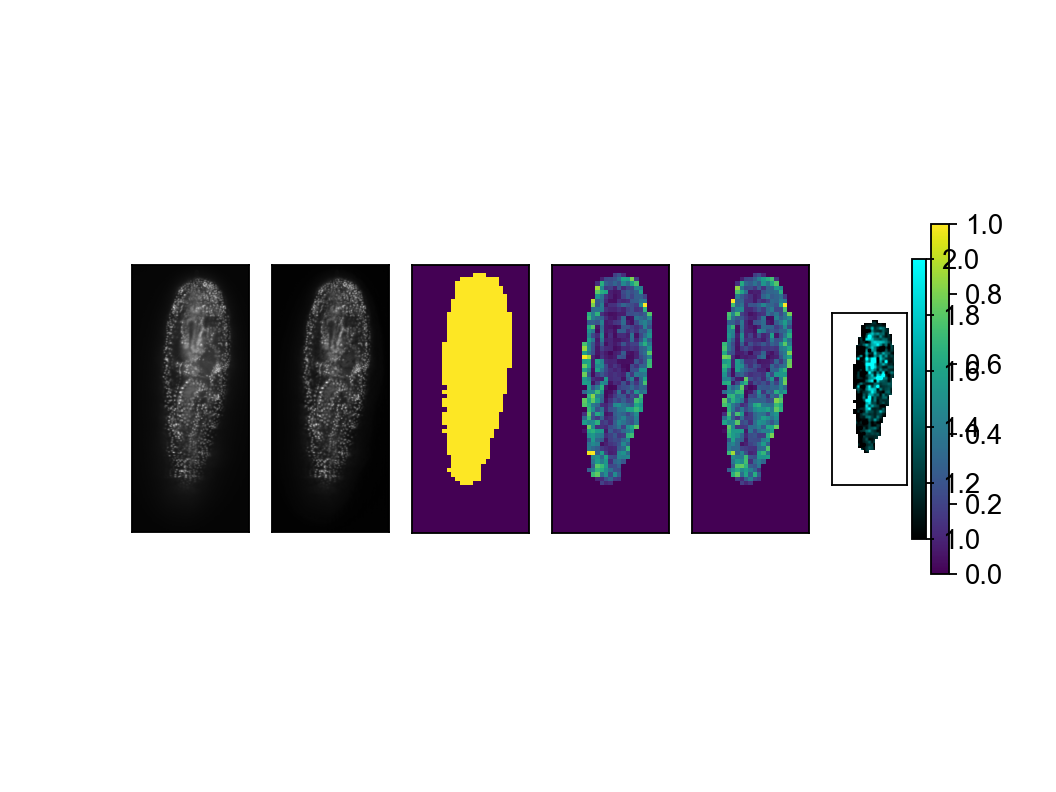

<ipython-input-43-ddc13a46ecb5>:31: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(b)
<ipython-input-43-ddc13a46ecb5>:32: RuntimeWarning: invalid value encountered in true_divide
  a = ax[5].imshow(plane1/plane0, cmap=cmap, clim=(1.,2.))
<ipython-input-43-ddc13a46ecb5>:39: RuntimeWarning: invalid value encountered in true_divide
  print(np.nanmean(plane1/plane0))


1.2317451110699429


In [43]:
%matplotlib notebook
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])
tp = 25
plane = 40
info_thr = 0.05

img0_tp = imread(filelists[0][tp])[plane]
img1_tp = imread(filelists[1][tp])[0][plane]

plane0 = infoss[0][tp][plane].copy()

mask = plane0>info_thr
mask = binary_dilation(mask,disk(1))
mask = np.pad(mask,100)
mask = remove_small_holes(mask, 1000)
mask = binary_erosion(mask,disk(2))
mask = mask[100:-100,100:-100]

plane0[mask==False] = 0.

plane1 = infoss[1][tp][plane].copy()
plane1[mask==False] = 0.

fig, ax = plt.subplots(1,6)
ax[0].imshow(img0_tp, cmap='gray')
ax[1].imshow(img1_tp, cmap='gray')
ax[2].imshow(mask)
ax[3].imshow(plane0, clim=(0.,1.))
b = ax[4].imshow(plane1, clim=(0.,1.))
plt.colorbar(b)
a = ax[5].imshow(plane1/plane0, cmap=cmap, clim=(1.,2.))
plt.colorbar(a)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

print(np.nanmean(plane1/plane0))

fig.savefig('visual_info_fly.pdf', dpi=900)

In [22]:
rel_info = []

for tp in range(infoss[0].shape[0]):
    
    rel_info_tp = []
    
    for z in range(infoss[0].shape[1]):
        
        plane0 = infoss[0][tp,z].copy()
        
        mask = plane0>info_thr
        mask = binary_dilation(mask,disk(1))
        mask = np.pad(mask,10)
        mask = remove_small_holes(mask, 1000)
        mask = binary_erosion(mask,disk(2))
        mask = mask[10:-10,10:-10]
        
        plane0[mask==False] = 0.
        
        plane1 = infoss[1][tp,z].copy()
        plane1[mask==False] = 0.
        
        rel = plane1/plane0
#         rel = rel.ravel()
#         rel = rel[rel>0.5]
        
        rel_info_plane = np.nanmean(rel)
        rel_info_tp.append(rel_info_plane)

    rel_info.append(rel_info_tp)

rel_info = np.array(rel_info)
    
print(rel_info[0,60])

<ipython-input-22-3ecf3c26e7e3>:23: RuntimeWarning: invalid value encountered in true_divide
  rel = plane1/plane0
<ipython-input-22-3ecf3c26e7e3>:27: RuntimeWarning: Mean of empty slice
  rel_info_plane = np.nanmean(rel)


1.6272634433839228


In [23]:
rel_info.shape

(26, 138)

<IPython.core.display.Javascript object>


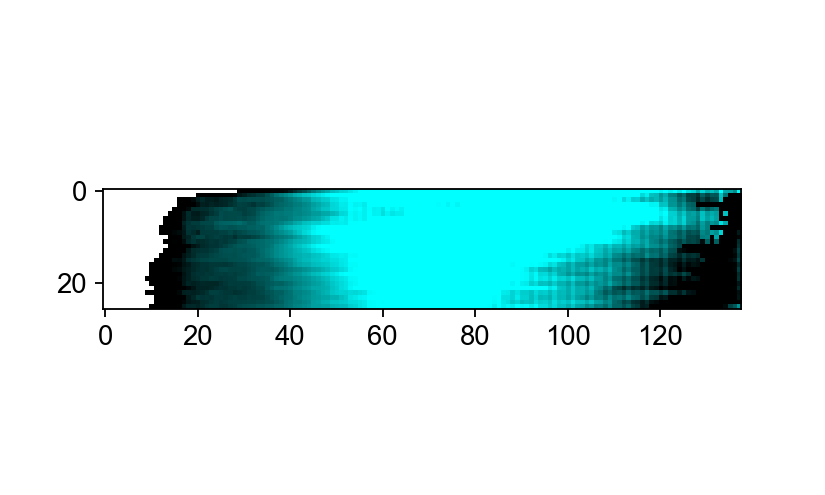

1.0557003746860103


In [24]:
fig,ax = plt.subplots(1,1,figsize=(5,3))
clims = (1.,1.5)

from matplotlib.colors import LinearSegmentedColormap
cmaps = [
    LinearSegmentedColormap.from_list('mycmap', ['red', 'black', 'cyan']),
    LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan']),
    LinearSegmentedColormap.from_list('mycmap', ['red', 'darkred', 'black', 'cyan', 'cyan'])]
ax.imshow(rel_info[:,:], cmap=cmaps[1], clim=clims)
    
print(rel_info[0,40])

<IPython.core.display.Javascript object>


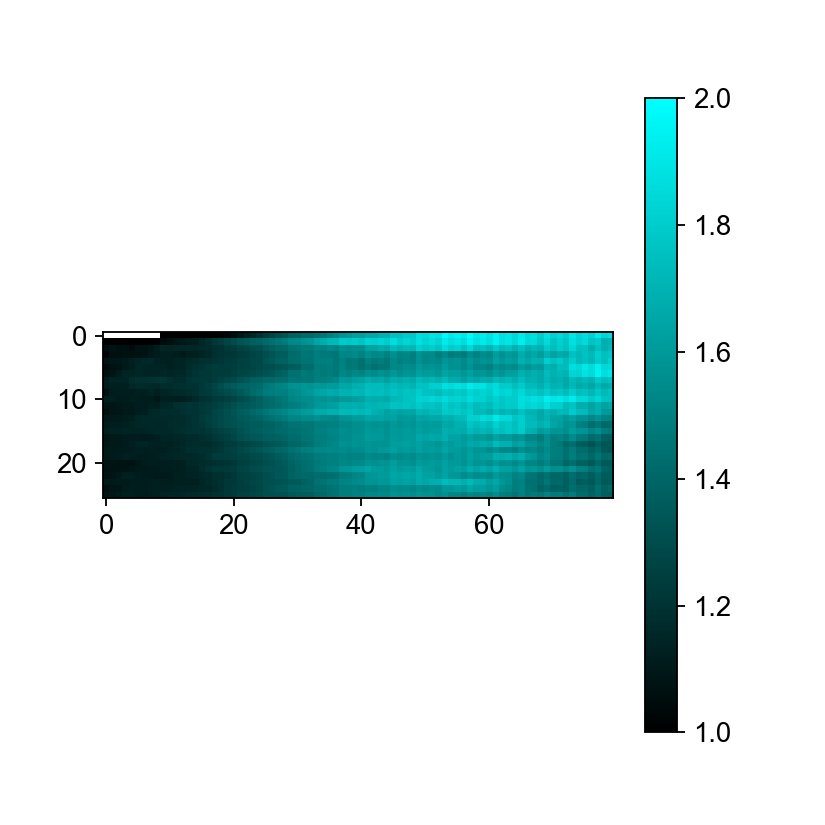

1.0557003746860103


In [25]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'cyan'])

fig,ax = plt.subplots(1,1,figsize=(5,5))
a=ax.imshow(rel_info[:,20:100], cmap=cmap, clim=(1.,2.))

plt.colorbar(a)

fig.savefig('info_gain.pdf', dpi=600)
print(rel_info[0,40])

In [26]:
print([(i, np.nanmax(infos_rest_max[i])) for i in range(infos_rest_max.shape[0])])

NameError: name 'infos_rest_max' is not defined

In [27]:
img.shape

(140, 1969, 861)

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


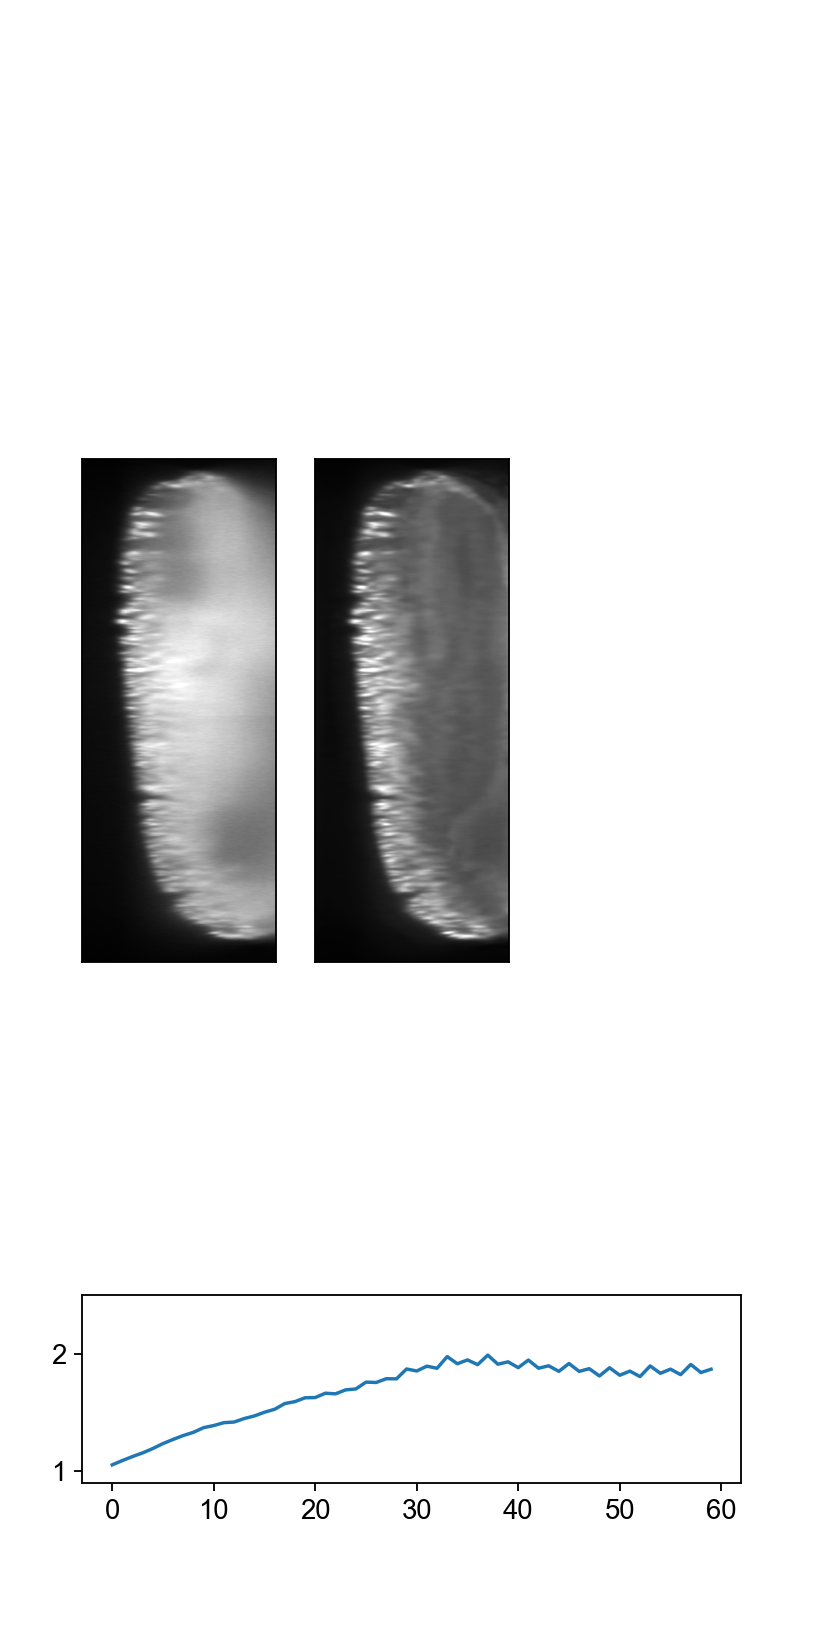

  0%|          | 0/2 [00:00<?, ?it/s]

(140, 1969, 861)
(1, 140, 1969, 861)


<IPython.core.display.Javascript object>


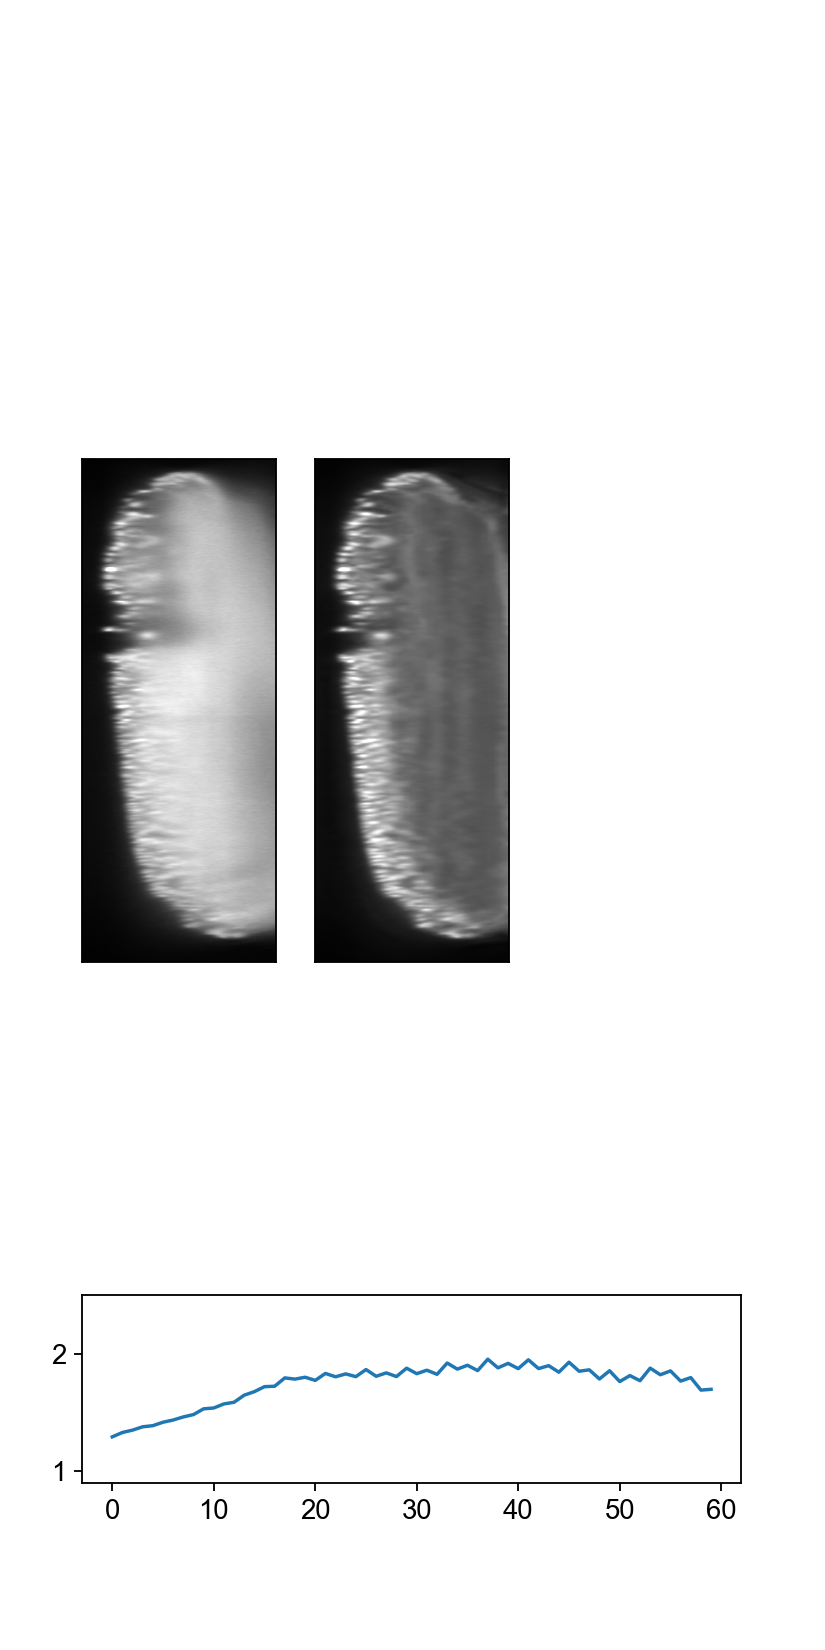

  0%|          | 0/2 [00:00<?, ?it/s]

(140, 1969, 861)
(1, 140, 1969, 861)


<IPython.core.display.Javascript object>


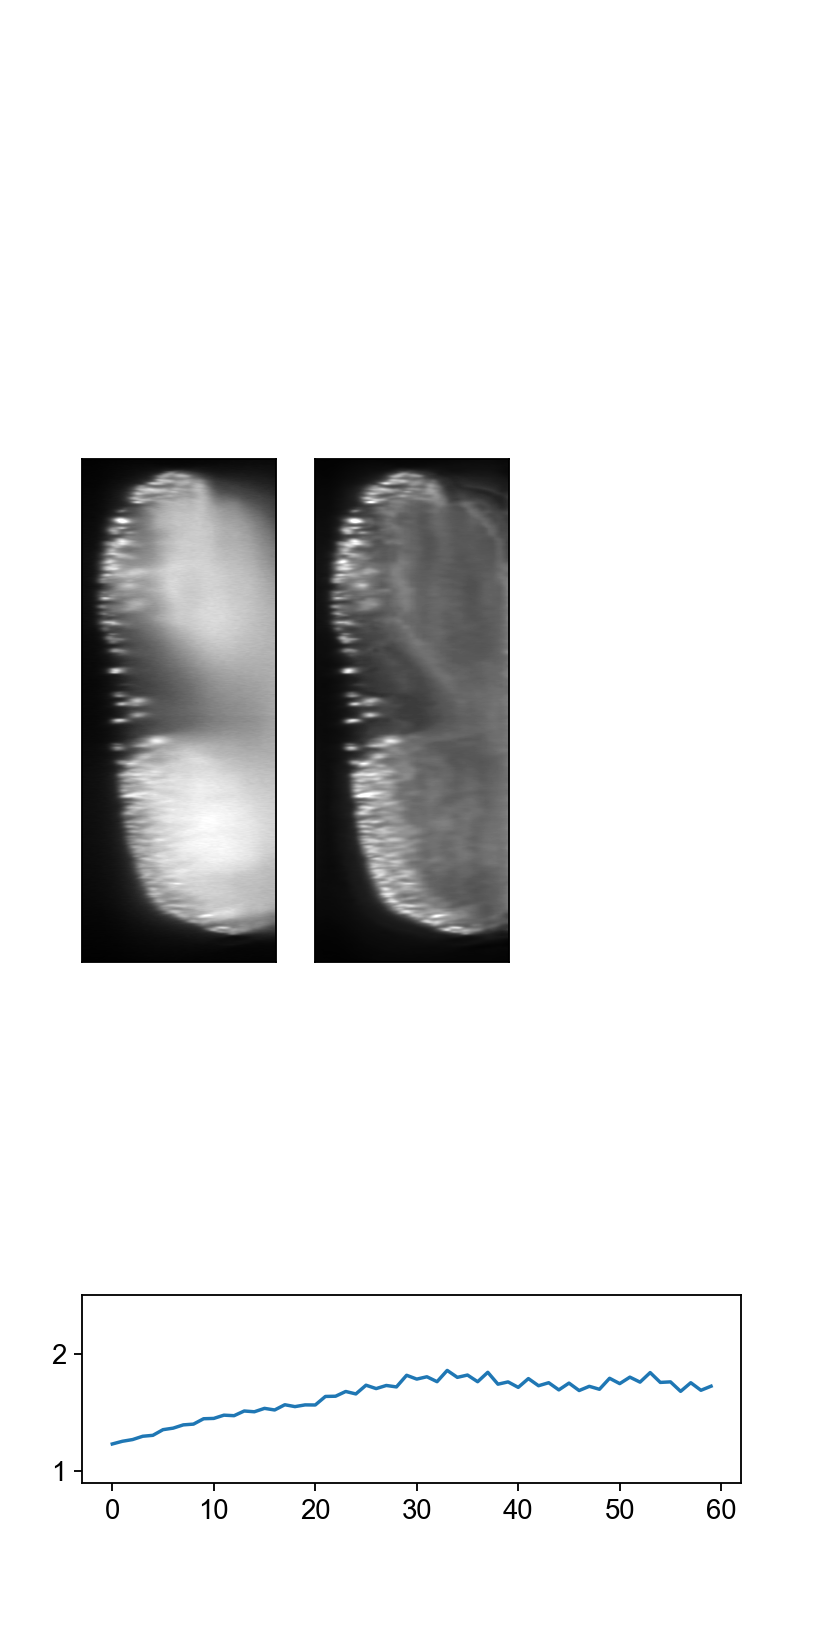

  0%|          | 0/2 [00:00<?, ?it/s]

(140, 1969, 861)
(1, 140, 1969, 861)


In [28]:
for i, idx in tqdm(enumerate([3, 17, 25]), total=3):
    fig = plt.figure(figsize=(5,10))
    gs = fig.add_gridspec(6, 3)
    ax1 = fig.add_subplot(gs[0:-1, 0])
    ax2 = fig.add_subplot(gs[0:-1, 1])
    ax3 = fig.add_subplot(gs[-1, :])
    
    fig.subplots_adjust(right=0.9, left=0.1, top=0.9, bottom=0.1)#, wspace=0.2)
    
    ax = [ax1,ax2,ax3]
#     fig, ax = plt.subplots(3,3, figsize=(5,15))
    for j, filelist in tqdm(enumerate(filelists[:2]), leave=False, total=2):
        img = imread(filelist[i])
        print(img.shape)
        if len(img.shape)==4:
            img = img[0]
        ax[j].imshow(resize(img[10:,50:1900,430],(750,1947), order=1, preserve_range=True).T, 
                       cmap='gray',
                       clim=(100,2000))
    ax[2].plot(rel_info[i,40:100])
    ax[2].set_ylim(.9,2.5)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    fig.savefig('comparison_%d.pdf'%i, dpi=600)

<IPython.core.display.Javascript object>


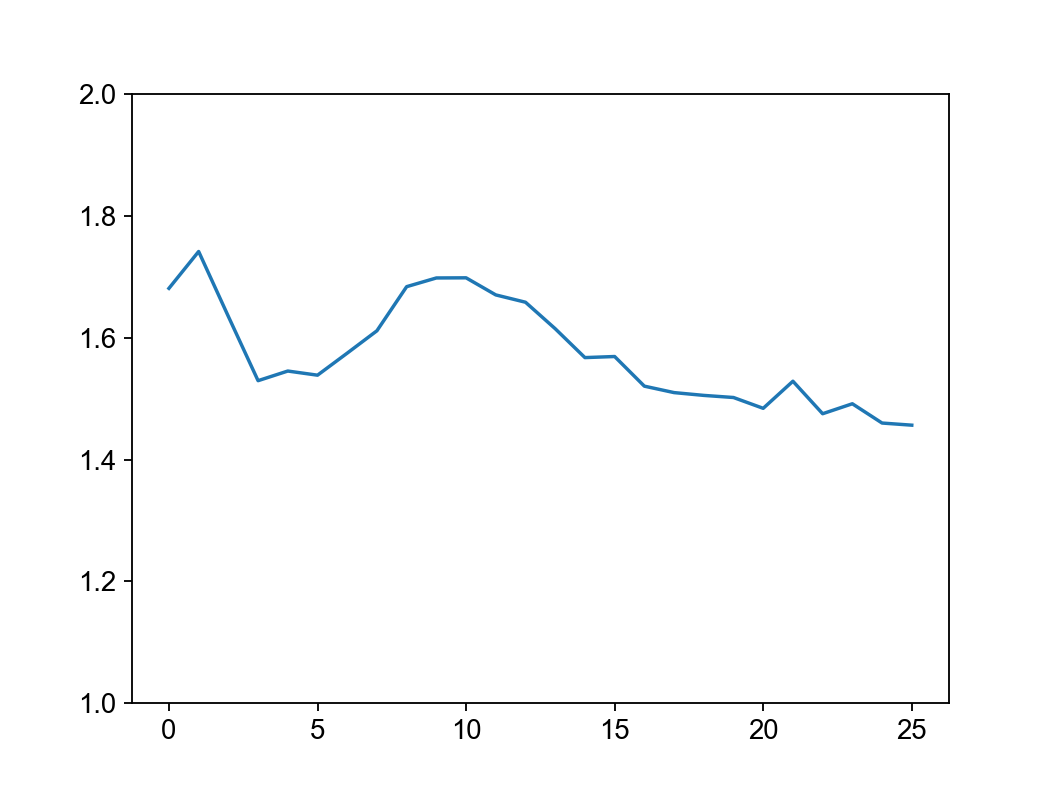

In [29]:
fig,ax = plt.subplots()
ax.plot(np.mean(rel_info[:,40:100],1))
ax.set_ylim(1.0,2.)#1.2)
fig.savefig('info_content_vs_t.pdf')

<IPython.core.display.Javascript object>


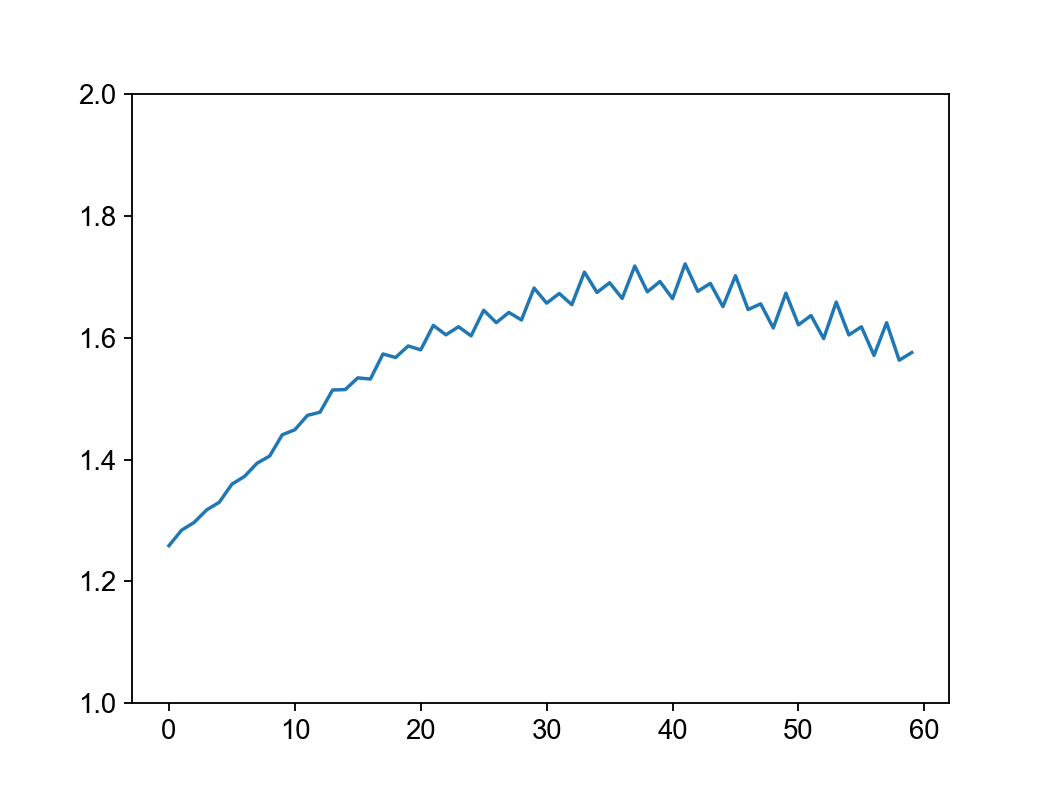

In [30]:
fig,ax = plt.subplots()
ax.plot(np.mean(rel_info[:,40:100],0))
ax.set_ylim(1.0,2.)#1.2)
fig.savefig('info_content_vs_depth.pdf')

In [31]:
img0 = np.stack([imread(f) for f in tqdm(filelists[0][::1])])
img1 = np.stack([imread(f)[0] for f in tqdm(filelists[1][::1])])

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [44]:
img1.shape

(26, 140, 1969, 861)

In [46]:

# img0 = imread(filelists[0][20])
# img1 = imread(filelists[1][20])[0]

import napari
from napari_animation import AnimationWidget

v = napari.Viewer()
animation_widget = AnimationWidget(v)
v.add_image(img0, scale=(1,1,1))
v.add_image(img1, scale=(1,1,1))
v.window.add_dock_widget(animation_widget, area='right')
napari.run()

C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = canvas_size / scale


In [75]:
video_gfp = []

In [101]:
video_gfp.append(v.screenshot())

In [102]:
video= np.stack(video_gfp)

imsave('rec_XY_1plane.tif', video)

<IPython.core.display.Javascript object>


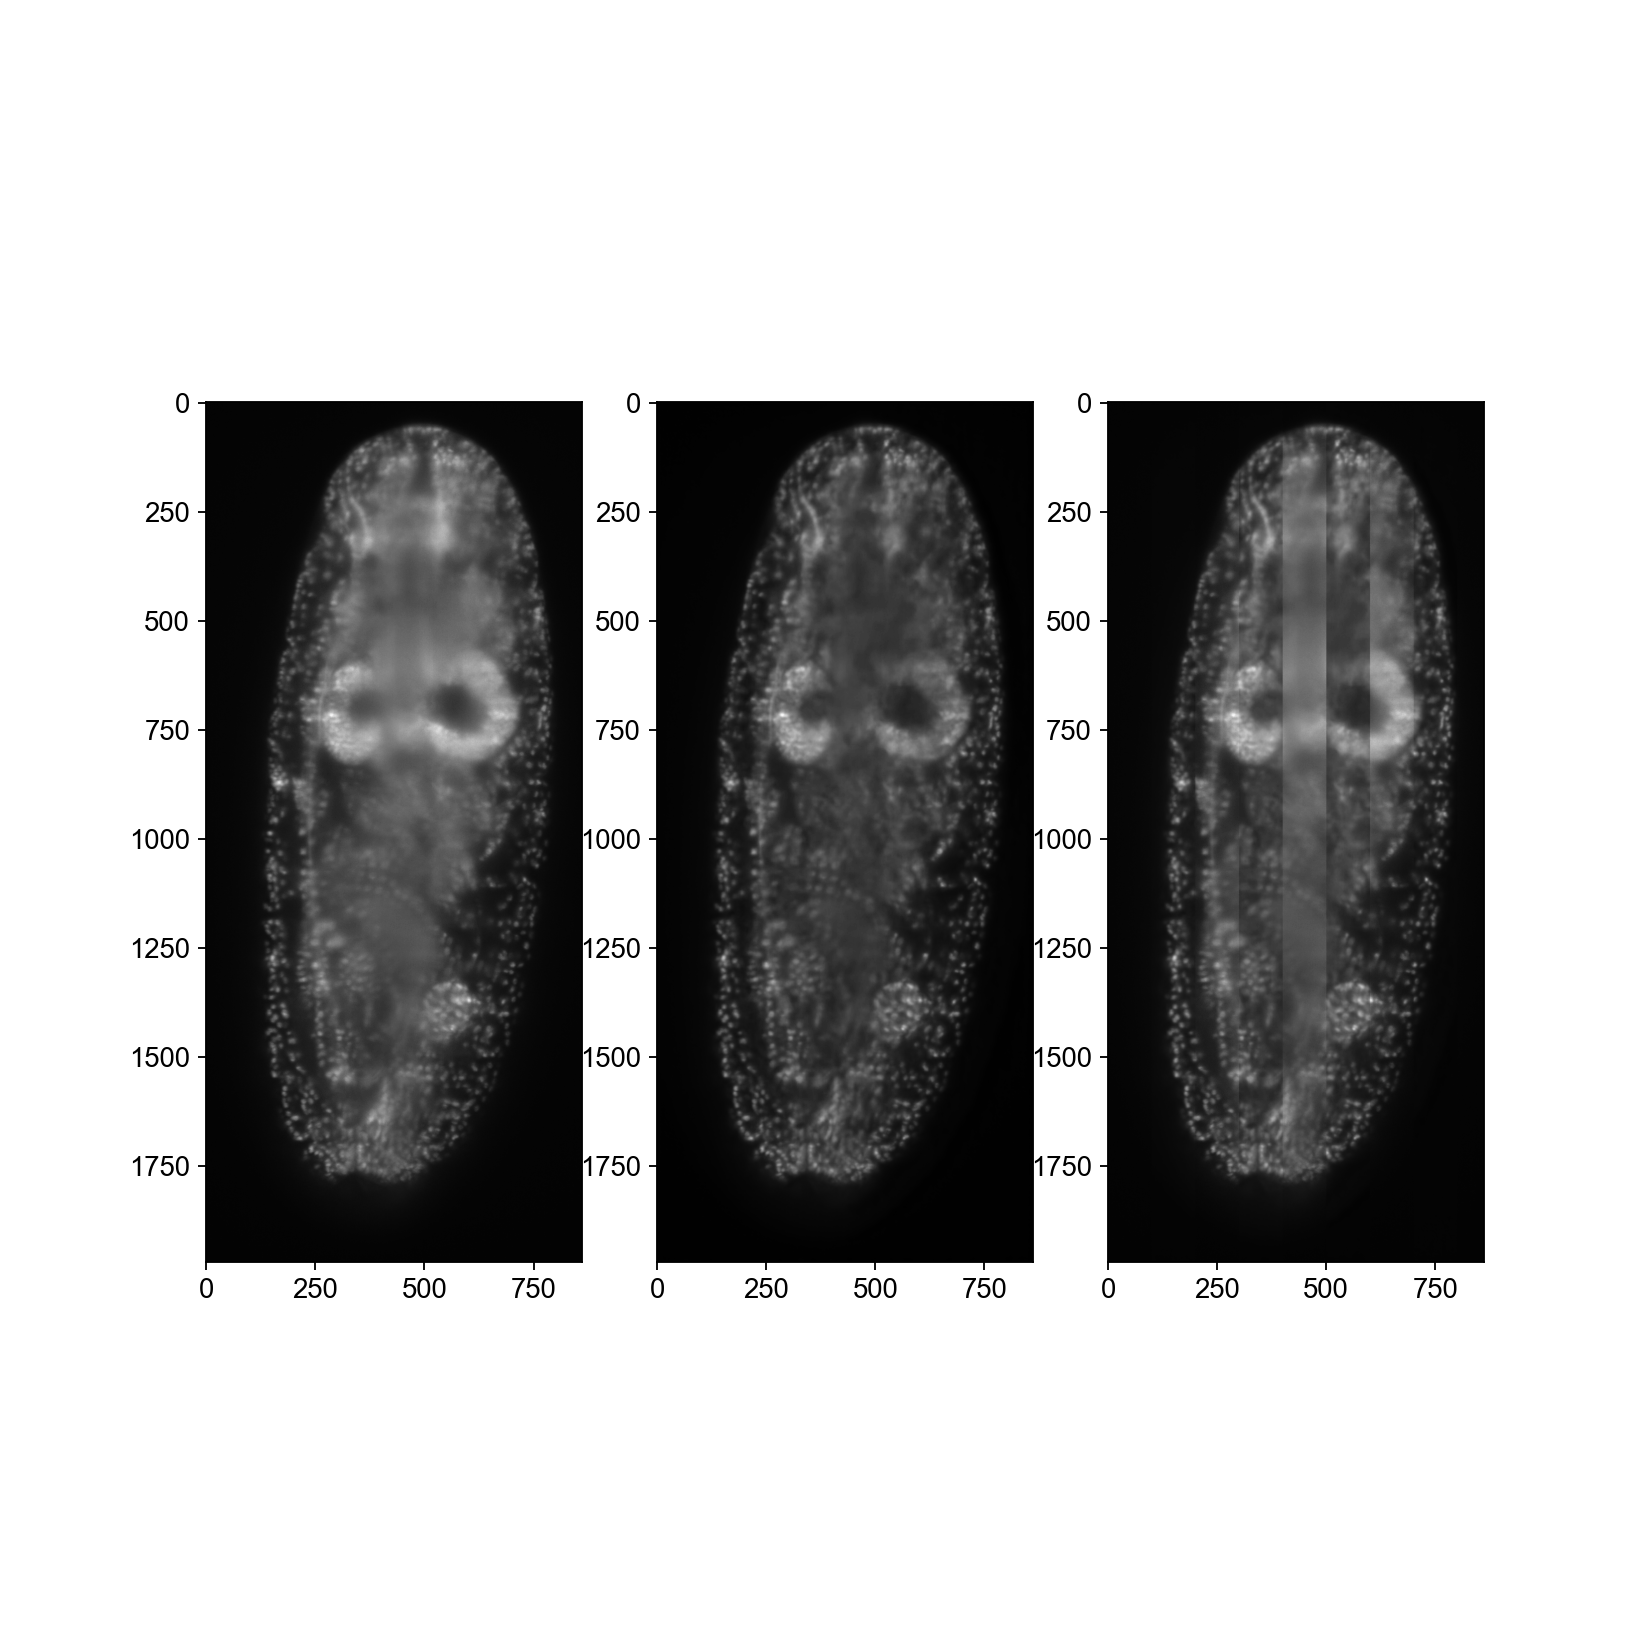

In [37]:
tp = 25

fig, ax = plt.subplots(1,3,figsize=(10,10))
imgs = np.stack([img0[tp],img1[tp]])


img = np.concatenate((imgs[0,70,:,:100],
                     imgs[1,70,:,100:200],
                     imgs[0,70,:,200:300],
                     imgs[1,70,:,300:400],
                     imgs[0,70,:,400:500],
                     imgs[1,70,:,500:600],
                     imgs[0,70,:,600:700],
                     imgs[1,70,:,700:800],
                     imgs[0,70,:,800:],), axis=1)

ax[0].imshow(img0[tp,70], cmap='gray')
ax[1].imshow(img1[tp,70], cmap='gray')
ax[2].imshow(img, cmap='gray')

